In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats.stats import sem, zscore, pearsonr, spearmanr
from matplotlib import pyplot as plt
from cxy_visual_dev.lib.predefine import proj_dir, Atlas, get_rois, mmp_name2label
from magicbox.algorithm.array import summary_across_col_by_mask
from magicbox.algorithm.plot import prepare_y_bar_line, plot_bar, plot_line, show_bar_value

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/line_bar')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# Plot RSM5

## all sorted visual ROIs

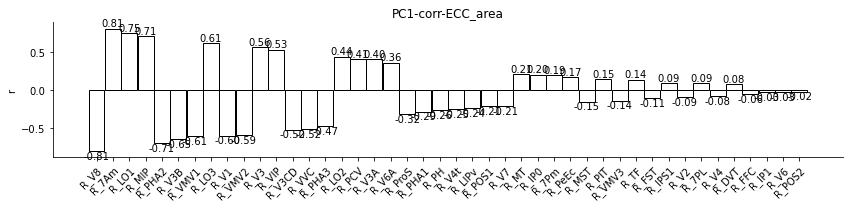

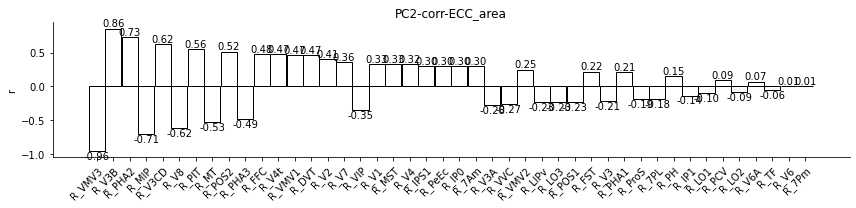

In [7]:
fpath = pjoin(anal_dir, 'RSM/RSM5_PC12-corr-ECC_area.pkl')
data = pkl.load(open(fpath, 'rb'))
out_file = pjoin(work_dir, 'RSM5_PC{}-corr-ECC_area.jpg')
for pc_idx, pc_name in enumerate(data['row_name']):
    sort_indices = np.argsort(np.abs(data['r'][pc_idx]))[::-1]
    y = data['r'][pc_idx][sort_indices]
    xticklabels = tuple(data['col_name'][i] for i in sort_indices)
    plot_bar(y, figsize=(12, 3), fc_ec_flag=True, fc=('w',), ec=('k',),
            show_height='.2f', xticklabel=xticklabels, rotate_xticklabel=True, ylabel='r',
            title=f'PC{pc_idx+1}-corr-ECC_area', mode=out_file.format(pc_idx+1))

# Predict

## PC_predict_ROI6

### 将多个文件的正确率按照一定的排列画到一张图上

R_V1~4's true ROI keys: [1 2 3]
MMP-vis3-R_ex(V1~4)'s true ROI keys: [1 2 3]
R_V1~4's true ROI keys: [1 2 3]
MMP-vis3-R_ex(V1~4)'s true ROI keys: [1 2 3]


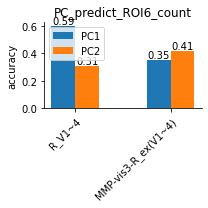

In [12]:
figsize = (4.8, 8)
trg = 'count'
title = f'PC_predict_ROI6_{trg}'
pc_names = ('PC1', 'PC2')
n_pc = len(pc_names)
mask_names = ('R_V1~4', 'MMP-vis3-R_ex(V1~4)')
n_mask = len(mask_names)
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_mask-{mask_name}.pkl')
out_file = pjoin(work_dir, f'{title}.jpg')

accs = np.zeros((n_pc, n_mask))
for pc_idx, pc_name in enumerate(pc_names):
    for mask_idx, mask_name in enumerate(mask_names):
        data = pkl.load(open(
            pkl_file.format(title=title, pc_name=pc_name, mask_name=mask_name), 'rb'
        ))
        accs[pc_idx, mask_idx] = np.mean(data['y_true'] == data['y_pred'])
        print(f"{mask_name}'s true ROI keys:", np.unique(data['y_true']))
plot_bar(accs, figsize=(3, 3), label=pc_names, xticklabel=mask_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='accuracy', mode=out_file, title=title)

## PC_predict_ROI4/5

### 对每个文件，输出基本信息，以及类别正确率和大小（按照类别正确率由大到小排序）

#ROI: 44
train scores: [0.40541041319251436, 0.4059662775616083, 0.40385327899221934, 0.4153390144497962, 0.3962578732864024]
train score: 0.40536537149650814
train scores (new): [0.3750149289382539, 0.3713933709562038, 0.3796690307328605, 0.3860166824047844, 0.36159374506397096]
train score (new): 0.37473755161921474
test scores: [0.3837037037037037, 0.40296296296296297, 0.4225352112676056, 0.39288361749444034, 0.40252038547071906]
test score: 0.40092117617988626
pearsonr: (0.636969558866608, 0.0)
accuracy: 0.40091892693048764
accs corr sizes: (0.16033376439185945, 0.2984972326107484)
accs corr sizes (rank): SpearmanrResult(correlation=-0.13407112803616172, pvalue=0.3855850431292933)


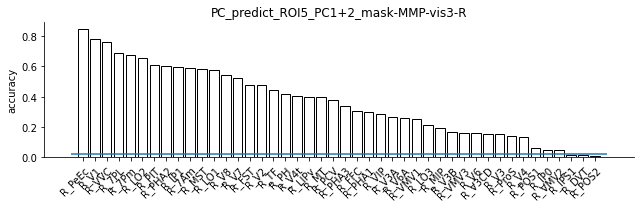

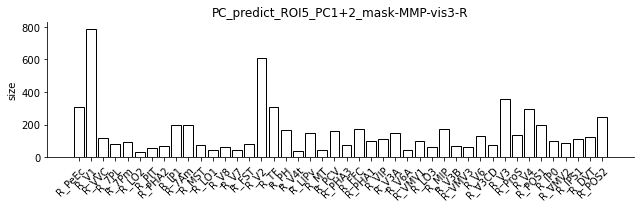

In [4]:
figsize = (9, 3)
# figsize = (8.5, 3)
# figsize = (2, 3)
fname = 'PC_predict_ROI5_PC1+2_mask-MMP-vis3-R'
pkl_file = pjoin(anal_dir, f'predict/{fname}.pkl')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')
out_file = True

pkl_data = pkl.load(open(pkl_file, 'rb'))
rois = pkl_data['roi_name']
n_roi = len(rois)
print('#ROI:', n_roi)
print('train scores:', pkl_data['train_score'])
print('train score:', np.mean(pkl_data['train_score']))
if 'ROI5' in fname:
    print('train scores (new):', pkl_data['train_score_new'])
    print('train score (new):', np.mean(pkl_data['train_score_new']))
print('test scores:', pkl_data['test_score'])
print('test score:', np.mean(pkl_data['test_score']))

y_true = pkl_data['y_true']
y_pred = pkl_data['y_pred']
print('pearsonr:', pearsonr(y_true, y_pred))
print('accuracy:', np.mean(y_true == y_pred))
class_accs = np.zeros(n_roi, np.float64)
class_sizes = np.zeros(n_roi, np.uint16)
for roi_idx, roi in enumerate(rois):
    class_mask = y_true == mmp_name2label[roi]
    y_true_tmp = y_true[class_mask]
    y_pred_tmp = y_pred[class_mask]
    class_accs[roi_idx] = np.mean(y_true_tmp == y_pred_tmp)
    class_sizes[roi_idx] = np.sum(class_mask)
sort_indices = np.argsort(class_accs)[::-1]
rois = tuple(rois[i] for i in sort_indices)
class_accs = class_accs[sort_indices]
class_sizes = class_sizes[sort_indices]
print('accs corr sizes:', pearsonr(class_accs, class_sizes))
print('accs corr sizes (rank):', spearmanr(class_accs, class_sizes))

x = np.arange(n_roi)
fig, ax = plt.subplots(figsize=figsize)
rects = ax.bar(x, class_accs, ec='k', fc='w')
# show_bar_value(rects, '.4f', ax)
ax.set_xticks(x)
ax.set_xticklabels(rois)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylabel('accuracy')
ax.set_title(fname)
ax.hlines(1/n_roi, x[0]-1, x[-1]+1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=figsize)
rects = ax2.bar(x, class_sizes, ec='k', fc='w')
ax2.set_xticks(x)
ax2.set_xticklabels(rois)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_ylabel('size')
ax2.set_title(fname)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig2.tight_layout()

if not out_file:
    fig.show()
    fig2.show()
else:
    fig.savefig(out_file1)
    fig2.savefig(out_file2)

### 将多个文件的正确率按照一定的排列画到一张图上

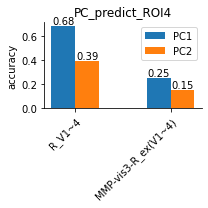

In [5]:
figsize = (4.8, 6.4)
title = 'PC_predict_ROI4'
pc_names = ('PC1', 'PC2')
n_pc = len(pc_names)
mask_names = ('R_V1~4', 'MMP-vis3-R_ex(V1~4)')
n_mask = len(mask_names)
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_mask-{mask_name}.pkl')
out_file = pjoin(work_dir, f'{title}.jpg')

accs = np.zeros((n_pc, n_mask))
for pc_idx, pc_name in enumerate(pc_names):
    for mask_idx, mask_name in enumerate(mask_names):
        data = pkl.load(open(
            pkl_file.format(title=title, pc_name=pc_name, mask_name=mask_name), 'rb'
        ))
        accs[pc_idx, mask_idx] = np.mean(data['y_true'] == data['y_pred'])
plot_bar(accs, figsize=(3, 3), label=pc_names, xticklabel=mask_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='accuracy', mode=out_file, title=title)

## PC12_predict_ROI2/3

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


44
train scores: [0.40541041319251436, 0.4059662775616083, 0.40385327899221934, 0.4153390144497962, 0.3962578732864024]
train score: 0.40536537149650814
train scores (new): [0.3750149289382539, 0.3713933709562038, 0.3796690307328605, 0.3860166824047844, 0.36159374506397096]
train score (new): 0.37473755161921474
test scores: [0.3837037037037037, 0.40296296296296297, 0.4225352112676056, 0.3936249073387695, 0.40252038547071906]
test score: 0.40106943414875207
pearsonr: (0.6369658863971307, 0.0)
accuracy: 0.401067140951534
accs corr sizes: (0.16066151326179556, 0.2974975900679198)
accs corr sizes (rank): SpearmanrResult(correlation=-0.13407112803616172, pvalue=0.3855850431292933)


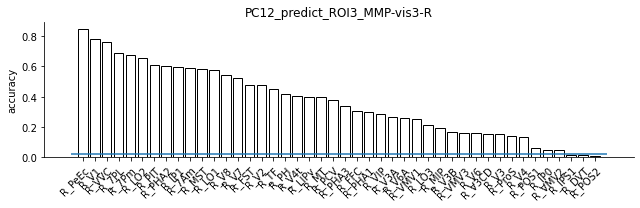

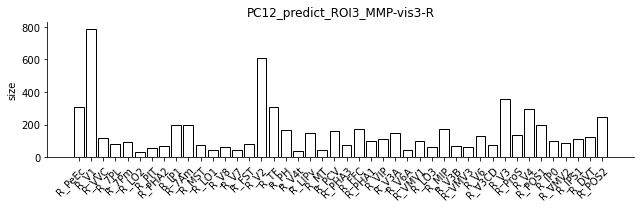

In [2]:
figsize = (9, 3)
vis_name = 'MMP-vis3-R'
atlas = Atlas('HCP-MMP')
rois = get_rois(vis_name)
mask = atlas.get_mask(rois)
fname = f'PC12_predict_ROI3_{vis_name}'
pkl_file = pjoin(anal_dir, f'predict/{fname}.pkl')
cii_file = pjoin(anal_dir, f'predict/{fname}.dlabel.nii')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')
out_file = True

n_roi = len(rois)
print(n_roi)
pkl_data = pkl.load(open(pkl_file, 'rb'))
print('train scores:', pkl_data['train_score'])
print('train score:', np.mean(pkl_data['train_score']))
print('train scores (new):', pkl_data['train_score_new'])
print('train score (new):', np.mean(pkl_data['train_score_new']))
print('test scores:', pkl_data['test_score'])
print('test score:', np.mean(pkl_data['test_score']))

y_true = atlas.maps[mask]
y_pred = nib.load(cii_file).get_fdata()[mask]
print('pearsonr:', pearsonr(y_true, y_pred))
print('accuracy:', np.mean(y_true == y_pred))
class_accs = np.zeros(n_roi, np.float64)
class_sizes = np.zeros(n_roi, np.uint16)
for roi_idx, roi in enumerate(rois):
    class_mask = y_true == mmp_name2label[roi]
    y_true_tmp = y_true[class_mask]
    y_pred_tmp = y_pred[class_mask]
    class_accs[roi_idx] = np.mean(y_true_tmp == y_pred_tmp)
    class_sizes[roi_idx] = np.sum(class_mask)
sort_indices = np.argsort(class_accs)[::-1]
rois = tuple(rois[i] for i in sort_indices)
class_accs = class_accs[sort_indices]
class_sizes = class_sizes[sort_indices]
print('accs corr sizes:', pearsonr(class_accs, class_sizes))
print('accs corr sizes (rank):', spearmanr(class_accs, class_sizes))

x = np.arange(n_roi)
fig, ax = plt.subplots(figsize=figsize)
rects = ax.bar(x, class_accs, ec='k', fc='w')
# show_bar_value(rects, '.4f', ax)
ax.set_xticks(x)
ax.set_xticklabels(rois)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylabel('accuracy')
ax.set_title(fname)
ax.hlines(1/n_roi, x[0]-1, x[-1]+1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=figsize)
rects = ax2.bar(x, class_sizes, ec='k', fc='w')
ax2.set_xticks(x)
ax2.set_xticklabels(rois)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_ylabel('size')
ax2.set_title(fname)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig2.tight_layout()

if not out_file:
    fig.show()
    fig2.show()
else:
    fig.savefig(out_file1)
    fig2.savefig(out_file2)

# BigBrain

C1_corr_layer-mean-p: [7.97891216e-008 7.20004173e-202 0.00000000e+000 0.00000000e+000
 3.60552472e-079 1.02273429e-274]
C2_corr_layer-mean-p: [1.35131083e-142 4.15493331e-001 3.04998173e-009 9.16078254e-065
 9.49400553e-068 7.76108934e-026]


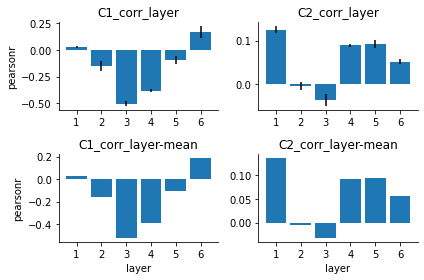

In [3]:
fname = '164fsLR2bigbrain_R_s2'
# fname = 'fsavg2bigbrain_R'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
y = [
    np.mean(data['C1_corr_layer'], 0),
    np.mean(data['C2_corr_layer'], 0),
    data['C1_corr_layer-mean'],
    data['C2_corr_layer-mean']]
yerr = [
    sem(data['C1_corr_layer'], 0),
    sem(data['C2_corr_layer'], 0),
    None, None]
title = [
    'C1_corr_layer', 'C2_corr_layer',
    'C1_corr_layer-mean', 'C2_corr_layer-mean']

print('C1_corr_layer-mean-p:', data['C1_corr_layer-mean-p'])
print('C2_corr_layer-mean-p:', data['C2_corr_layer-mean-p'])
plot_bar(
    y, 2, 2, yerr=yerr, xlabel='layer',
    xticklabel=data['layer_name'], ylabel='pearsonr',
    title=title, mode=out_file)

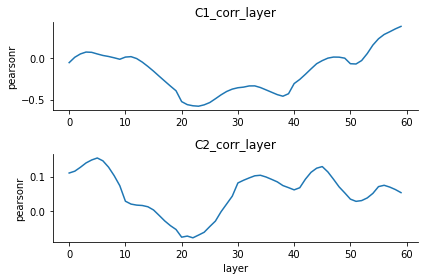

In [5]:
fname = '164fsLR2bigbrain_R_s2'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}_60.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
y = [
    data['C1_corr_layer'].reshape((-1,), order='F'),
    data['C2_corr_layer'].reshape((-1,), order='F')]
title = ['C1_corr_layer', 'C2_corr_layer']

plot_line(
    y, 2, 1, xlabel='layer', ylabel='pearsonr',
    title=title, mode=out_file,)

# ROI Scalar

## 画多个ROI随年龄的变化曲线

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


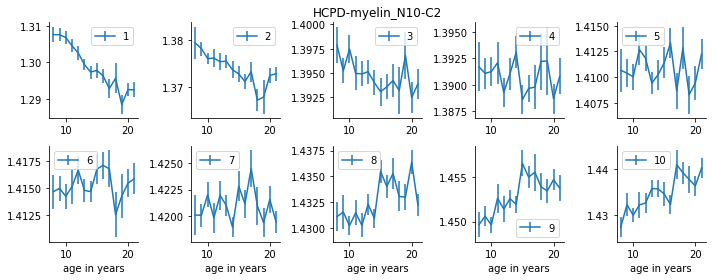

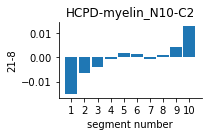

In [19]:
# set parameters
age_mask = 'remove567'
src_file = pjoin(anal_dir, 'ROI_scalar/HCPD-myelin_N10-C2.csv')
rois = [str(i) for i in np.arange(1, 11)]
arrange_flag = None  # OP-gdist, M+T-PC1
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
# n_row, n_col = 5, 9
# figsize = (18, 10)
# n_row, n_col = 1, 3
# figsize = (6, 2)
n_row, n_col = 2, 5
figsize = (10, 4)
ylim = None
title = 'HCPD-myelin_N10-C2'
mode1 = pjoin(work_dir, f'{title}-1.jpg')
mode2 = pjoin(work_dir, f'{title}-2.jpg')
# mode1 = 'show'
# mode2 = 'show'

# arrange ROIs
if arrange_flag is None:
    pass
elif arrange_flag == 'OP-gdist':
    # 依据各ROI离枕极的距离从小到大排序
    df_tmp = pd.read_csv(pjoin(
        anal_dir, 'ROI_scalar/gdist_src-OccipitalPole_HCP-MMP.csv'
    ))
    arrange_values = df_tmp.loc[0, rois]
    sort_indices = np.argsort(arrange_values)
    rois = [rois[i] for i in sort_indices]
elif arrange_flag == 'M+T-PC1':
    # 依据各ROI在HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj PC1中的均值从小到大排序
    df_tmp = pd.read_csv(pjoin(
        anal_dir, 'ROI_scalar/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_HCP-MMP.csv'
    ), index_col=0)
    arrange_values = df_tmp.loc['C1', rois]
    sort_indices = np.argsort(arrange_values)
    rois = [rois[i] for i in sort_indices]
else:
    raise ValueError

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True
)
key_groups = [(i,) for i in rois]
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), n_row=n_row, n_col=n_col, x=[ages_uniq]*len(rois),
    figsize=figsize, yerr=prepare_y_bar_line(yerr_dict, key_groups),
    label=key_groups, xlabel=age_name, ylim=ylim, title=title, mode=mode1
)

y2 = np.zeros(len(rois), np.float64)
for roi_idx, roi in enumerate(rois):
    y2[roi_idx] = y_dict[roi][-1] - y_dict[roi][0]
plot_bar(y2, figsize=(3, 2), show_height=None, xlabel='segment number',
         xticklabel=tuple(rois), ylabel='21-8', title=title, mode=mode2)

## 把多个ROI的发育趋势画到同一个ax里

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


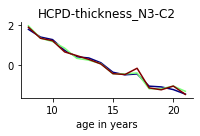

In [7]:
# set parameters
age_mask = 'remove567'
fname = 'HCPD-thickness_N3-C2'
src_file = pjoin(anal_dir, f'ROI_scalar/{fname}.csv')
rois = [str(i) for i in np.arange(1, 4)]
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, 3)
colors = tuple(cmap(color_indices[i]) for i in range(3))
labels = None
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
n_row, n_col = 1, 1
figsize = (3, 2)
zscore_flag = True
mode = pjoin(work_dir, f'{fname}.jpg')
# mode = 'show'

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True)
key_groups = [rois]
if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, n_row=n_row, n_col=n_col, x=ages_uniq, figsize=figsize, yerr=yerr,
    label=labels, xlabel=age_name, title=fname, mode=mode, color=colors
)

## 把ROI分组，同一组的画到同一个ax里

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


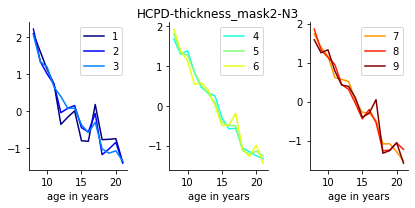

In [13]:
# set parameters
age_mask = 'remove567'
fname = 'HCPD-thickness_mask2-N3'
src_file = pjoin(anal_dir, f'ROI_scalar/{fname}.csv')
rois = [str(i) for i in np.arange(1, 10)]
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, 9)
colors = [
    tuple(cmap(color_indices[i]) for i in range(3)),
    tuple(cmap(color_indices[i]) for i in range(3, 6)),
    tuple(cmap(color_indices[i]) for i in range(6, 9))]
labels = [tuple(rois[:3]), tuple(rois[3:6]), tuple(rois[6:])]
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
n_row, n_col = 1, 3
n_ax = 3
figsize = (6, 3)
zscore_flag = True
mode = pjoin(work_dir, f'{fname}.jpg')
# mode = 'show'

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True)
key_groups = labels
if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, n_row=n_row, n_col=n_col, x=[ages_uniq] * n_ax, figsize=figsize,
    yerr=yerr, label=labels, xlabel=age_name, title=fname, mode=mode, color=colors
)

# Plot Age Distribution

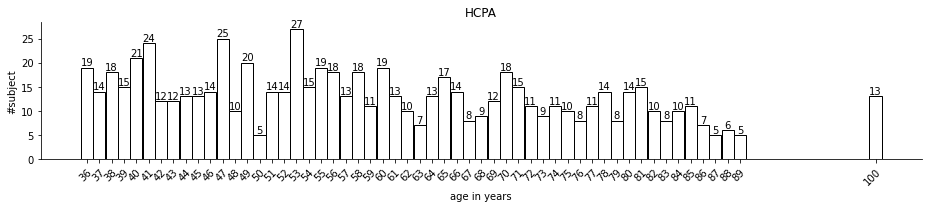

In [9]:
dataset_name = 'HCPA'
# figsize = (6, 3)
figsize = (13, 3)
age_name = 'age in years'
fpath = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
out_file = pjoin(work_dir, f'{dataset_name}_age_dist.jpg')
# out_file = 'show'

df = pd.read_csv(fpath)
ages = np.array(df[age_name])
ages_uniq = np.unique(ages)

y = np.zeros_like(ages_uniq, int)
for idx, age in enumerate(ages_uniq):
    y[idx] = np.sum(ages == age)

plot_bar(y, figsize=figsize, x=ages_uniq, fc_ec_flag=True,
         fc=('w',), ec=('k',), show_height='', xlabel=age_name,
         xticklabel=ages_uniq, rotate_xticklabel=True,
         ylabel='#subject', title=dataset_name, mode=out_file)

# Plot Cluster

## 把detect_community1得到的各map的modularity用bar图展示

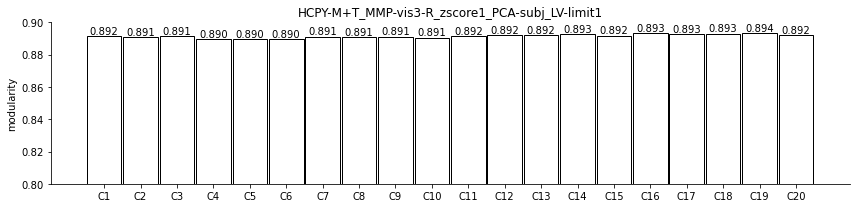

In [3]:
fname = 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_LV-limit1'
df = pd.read_csv(pjoin(anal_dir, f'cluster/{fname}.csv'))
plot_bar(np.array(df['modularity']), figsize=(12, 3) ,fc_ec_flag=True, fc=('w',), ec=('k',),
         show_height='.3f', xticklabel=tuple(df['name']), ylabel='modularity', ylim=(0.8, 0.9),
         title=fname, mode=pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_LV-limit1.jpg'))

# Plot Decomposition

## 可视化PCA各成分的解释方差

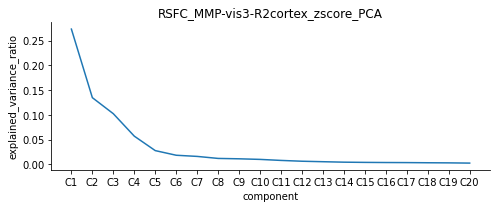

In [3]:
# settings
fname = 'RSFC_MMP-vis3-R2cortex_zscore_PCA'
components = 'all'
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

# start
data = pkl.load(open(pjoin(anal_dir, f'decomposition/{fname}.pkl'), 'rb'))
if components == 'all':
    components = np.arange(data.n_components) + 1
else:
    components = np.array(components)
plot_line(
    y=data.explained_variance_ratio_[components - 1], n_row=1, n_col=1, figsize=(7, 3),
    yerr=None, x=None, label=None, color=None, mode=out_file, xlabel='component',
    xtick=None, xticklabel=tuple(f'C{i}' for i in components), rotate_xticklabel=False,
    ylabel='explained_variance_ratio', ylim=None, title=fname
)

## 把多个模态同一个成分的权重时间序列画到只有单个ax的fig里（线图）

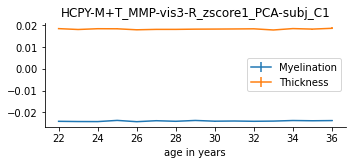

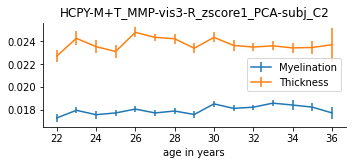

In [10]:
# settings
zscore_flag = False
fnames = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv'
]
labels = ('Myelination', 'Thickness')
cols = ['C1', 'C2']
key_groups_list = [[['0-C1', '1-C1']], [['0-C2', '1-C2']]]
titles = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C1',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C2'
]
out_files = [
    pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C1.jpg'),
    pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_C2.jpg')
]
# out_files = ['show', 'show']

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPY'])[age_name]
ages_uniq = np.unique(ages).tolist()
ages_uniq.remove(37)
ages_uniq = np.array(ages_uniq)

# start
data = []
row_names = []
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    data.append(np.array(df[cols]).T)
    row_names.extend([f'{f_idx}-{col}' for col in cols])
data = np.concatenate(data, 0)
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=False, row_names=row_names, zscore_flag=zscore_flag, out_dict=True
)
for i, key_groups in enumerate(key_groups_list):
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
    plot_line(y, n_row=1, n_col=1, figsize=(5, 2.4), yerr=yerr, x=ages_uniq,
              label=labels, color=None, mode=out_files[i], xlabel=age_name, xtick=None,
              xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=titles[i])

## 把多个成分多个模态的权重平均大小画到只有单个ax的fig里（bar图）

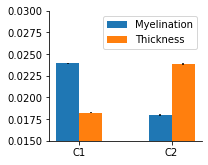

In [10]:
# settings
fnames = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv'
]
meas = ('Myelination', 'Thickness')
cols = ('C1', 'C2')
ylim = (0.015, 0.03)
# ylim = None
# out_file = pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.jpg')
out_file = 'show'

# start
n_fname = len(fnames)
n_col = len(cols)
y = np.zeros((n_fname, n_col), np.float64)
yerr = np.zeros((n_fname, n_col), np.float64)
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    for col_idx, col in enumerate(cols):
        samples = np.array(df[col])
        samples = np.abs(samples[~np.isnan(samples)])
        y[f_idx, col_idx] = np.mean(samples)
        yerr[f_idx, col_idx] = sem(samples)
plot_bar(
    y, n_row=1, n_col=1, figsize=(3, 2.4), yerr=yerr, x=None, width=None,
    label=meas, color=None, show_height=None, mode=out_file, xlabel=None,
    xticklabel=cols, rotate_xticklabel=False, ylabel=None, ylim=ylim, title=None
)

## 把多个成分多个模态的权重占比画到只有单个ax的fig里（bar图）

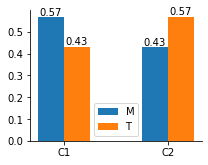

In [13]:
# settings
fnames = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv'
]
# meas = ('Myelination', 'Thickness')
meas = ('M', 'T')
cols = ('C1', 'C2')
out_file = pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.jpg')
# out_file = 'show'

# start
n_fname = len(fnames)
n_col = len(cols)
y = np.zeros((n_fname, n_col), np.float64)
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    for col_idx, col in enumerate(cols):
        samples = np.array(df[col])
        samples = np.abs(samples[~np.isnan(samples)])
        y[f_idx, col_idx] = np.sum(samples)
y /= np.sum(y, 0, keepdims=True)
plot_bar(
    y, figsize=(3, 2.4), label=meas, mode=out_file, show_height='.2f',
    xticklabel=cols, ylabel=None)

## 把单个文件中的不同column画到不同ax里

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


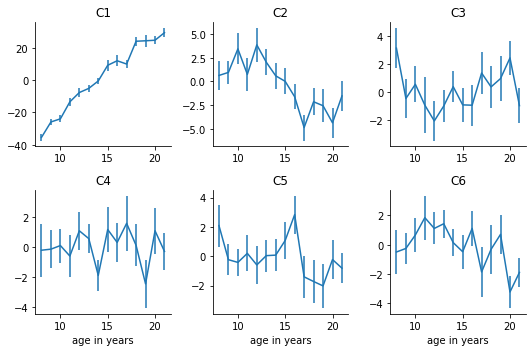

In [13]:
# settings
fname = 'HCPD-T_MMP-vis3-R_zscore0_PCA-vtx'
fpath = pjoin(anal_dir, f'decomposition/{fname}.csv')
cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

age_name = 'age in years'
ages = pd.read_csv(pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv'))[age_name]
ages_uniq = np.unique(ages).tolist()
print(ages_uniq)
for age in [5, 6, 7]:
    ages_uniq.remove(age)
print(ages_uniq)
ages_uniq = np.array(ages_uniq)

# start
n_col = len(cols)
df = pd.read_csv(fpath)
data = np.array(df[cols]).T
y, yerr = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=False, row_names=None, zscore_flag=False, out_dict=False
)
key_groups = [[i] for i in range(n_col)]
y = prepare_y_bar_line(y, key_groups)
yerr = prepare_y_bar_line(yerr, key_groups)
plot_line(y, n_row=2, n_col=3, figsize=(7.5, 5), yerr=yerr, x=[ages_uniq]*n_col,
          label=None, color=None, mode=out_file, xlabel=age_name, xtick=None,
          xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=cols)

# Plot Fit

## HCPD-M+T=C1C2.csv

### 现有的column

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


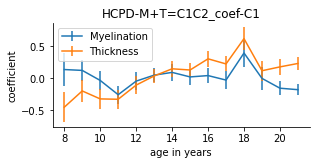

In [19]:
# load data
dataset_name = 'HCPD'
fname = f'{dataset_name}-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)
print(ages_uniq)
ages_uniq = ages_uniq[3:]
print(ages_uniq)

# prepare plot contents
cols = ['coef_C1_Myelination', 'coef_C1_Thickness']
labels = ('Myelination', 'Thickness')
ylabel='coefficient'
title = f'{fname}_coef-C1'

# cols = ['score_C1']
# labels = None
# ylabel='R2'
# title = f'{fname}_score-C1'

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = True
key_groups = [cols]

# get valid subjects
# outlier_vec1 = np.load(pjoin(anal_dir, f'outlier/{dataset_name}-myelin_MMP-vis3-R_RSM-IQR3.npy'))
# outlier_vec2 = np.load(pjoin(anal_dir, f'outlier/{dataset_name}-thickness_MMP-vis3-R_RSM-IQR3.npy'))
# non_outlier_vec = ~np.logical_or(outlier_vec1, outlier_vec2)
# data = data[:, non_outlier_vec]
# ages = ages[non_outlier_vec]
# ages_uniq = np.unique(ages)

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, zscore_flag=zscore_flag, out_dict=True
)
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), figsize=figsize,
    yerr=prepare_y_bar_line(yerr_dict, key_groups), x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel
)


### (|M|-|T|)/(|M|+|T|)

Warning! The sample size of value-6 is 5.
Warning! The sample size of value-7 is 5.


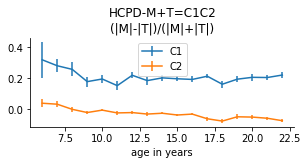

In [9]:
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

figsize = (4.5, 2.4)
labels = ('C1', 'C2')
data = np.zeros((len(labels), df.shape[0]), np.float64)
for lbl_idx, lbl in enumerate(labels):
    m = np.abs(df[f'coef_{lbl}_Myelination'])
    t = np.abs(df[f'coef_{lbl}_Thickness'])
    data[lbl_idx, :] =  (m - t) / (m + t)
title = f'{fname}\n(|M|-|T|)/(|M|+|T|)'
out_file = pjoin(work_dir, f'{fname}_MT-diff.jpg')
# out_file = 'show'

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq,
    label=labels, xlabel=age_name, title=title, mode=out_file
)


### |M|-|T|

Warning! The sample size of value-6 is 4.
Warning! The sample size of value-7 is 5.


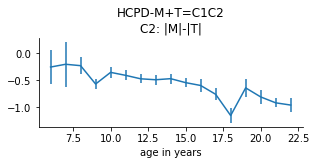

In [12]:
# load data
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

# prepare plot contents
figsize = (4.5, 2.4)
lbl = 'C2'
data = np.zeros((1, df.shape[0]), np.float64)
m = np.abs(df[f'coef_{lbl}_Myelination'])
t = np.abs(df[f'coef_{lbl}_Thickness'])
data[0, :] =  m - t
title = f'{fname}\n{lbl}: |M|-|T|'
out_file = pjoin(work_dir, f'{fname}_MT-diff-{lbl}.jpg')
# out_file = 'show'

# get valid subjects
outlier_vec1 = np.load(pjoin(anal_dir, 'outlier/HCPD-myelin_MMP-vis3-R_RSM-IQR3.npy'))
outlier_vec2 = np.load(pjoin(anal_dir, 'outlier/HCPD-thickness_MMP-vis3-R_RSM-IQR3.npy'))
non_outlier_vec = ~np.logical_or(outlier_vec1, outlier_vec2)
data = data[:, non_outlier_vec]
ages = ages[non_outlier_vec]
ages_uniq = np.unique(ages)

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, xlabel=age_name,
    title=title, mode=out_file
)

## CalcS+OcPole+MT=C1.csv

score: 0.22387787046567784


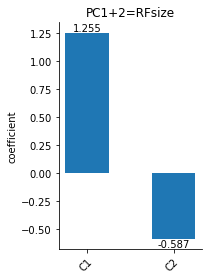

In [2]:
# fname = 'CalcS+OcPole+MT=C1'
# fname = 'CalcS+MT=C1'
# fname = 'OcPole+MT=C1'
fname = 'PC1+2=RFsize'
trg_name = 'RFsize'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score:', df[f'score_{trg_name}'].item())
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith(f'coef_{trg_name}_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 4), show_height='.3f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode=out_file)

## PC1+2=fALFF_ind.csv

score: 0.21015780590137687±0.002423204638360952


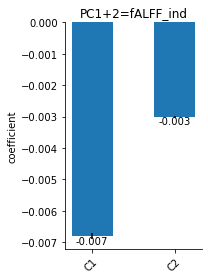

In [4]:
fname = 'PC1+2=fALFF_ind'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score: {0}±{1}'.format(np.mean(df['score']), sem(df['score'])))
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith('coef_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
coef_data = np.array(df[coef_names])
y = np.mean(coef_data, 0)
yerr = sem(coef_data, 0)
plot_bar(y=y, figsize=(3, 4), show_height='.3f', yerr=yerr,
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode=out_file)

## Mean8+Tau+Diff=C1C2.csv

score_C1: 0.9636226915861064


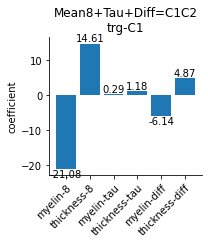

In [9]:
fname = 'Mean8+Tau+Diff=C1C2'
# fname = 'Mean8=C1C2'
pc_num = 'C1'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print(f'score_{pc_num}:', df[f'score_{pc_num}'].item())
out_file = pjoin(work_dir, f'{fname}_{pc_num}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith(f'coef_{pc_num}_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 3.5), show_height='.2f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=f'{fname}\ntrg-{pc_num}', mode=out_file)

## HCPD-M+T=C1C2_local-mask1-N3-R.csv

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


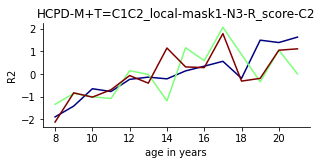

In [6]:
# load data
N = 3
dataset_name = 'HCPD'
fname = f'{dataset_name}-M+T=C1C2_local-mask1-N{N}-R'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)
print(ages_uniq)
ages_uniq = ages_uniq[3:]
print(ages_uniq)

# prepare plot contents
cols = [f'score_C2-{i}' for i in range(1, N+1)]
labels = tuple(i[-1] for i in cols)
labels = None
ylabel='R2'
title = f'{fname}_score-C2'
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, N)
colors = tuple(cmap(color_indices[i]) for i in range(N))

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = True
key_groups = [cols]

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, out_dict=True
)

if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel, color=colors
)


## HCPD/A-M+T=C1C2_MMP-vis3-R-EDMV

[ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 100]
[ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 100]
Warning! The sample size of value-50 is 5.
Warning! The sample size of value-63 is 7.
Warning! The sample size of value-67 is 8.
Warning! The sample size of value-68 is 9.
Warning! The sample size of value-73 is 9.
Warning! The sample size of value-76 is 8.
Warning! The sample size of value-79 is 8.
Warning! The sample size of value-83 is 8.
Warning! The sample size of value-86 is 7.
Warning! The sample size of value-87 is 5.
Warning! The sample size of value-88 is 6.
Warning! The sample size of value-89 is 5.


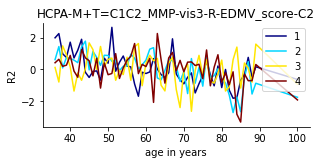

In [9]:
# load data
N = 4
dataset_name = 'HCPA'
fname = f'{dataset_name}-M+T=C1C2_MMP-vis3-R-EDMV'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)
print(ages_uniq)
if dataset_name == 'HCPD':
    ages_uniq = ages_uniq[3:]
print(ages_uniq)

# prepare plot contents
cols = [f'score_C2-{i}' for i in range(1, N+1)]
labels = tuple(i[-1] for i in cols)
# labels = None
ylabel='R2'
title = f'{fname}_score-C2'
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, N)
colors = tuple(cmap(color_indices[i]) for i in range(N))

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = True
key_groups = [cols]

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, out_dict=True
)

if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel, color=colors
)


## HCPD-M+T=C1C2_local-mask1-N3-R_AgeFitCol1.csv

remove 5/6/7
1 -0.016687421542859245
2 -0.03041684690858722
3 -0.025287467139545758


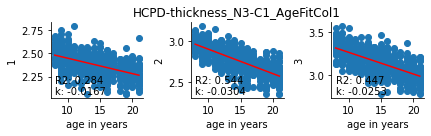

In [5]:
# data_name = 'HCPD'
# age_name = 'age in years'
# src_file1 = pjoin(anal_dir, f'fit/{data_name}-M+T=C1C2_local-mask1-N3-R_AgeFitCol1.csv')
# src_file2 = pjoin(anal_dir, f'fit/{data_name}-M+T=C1C2_local-mask1-N3-R.csv')
# info_file = pjoin(proj_dir, f'data/HCP/{data_name}_SubjInfo.csv')
# indices = ['score_C1-1', 'score_C1-2', 'score_C1-3', 'score_C2-1', 'score_C2-2', 'score_C2-3']
# n_row, n_col = 2, 3
# figsize = (9, 6)
# out_file = pjoin(work_dir, f'{data_name}-M+T=C1C2_local-mask1-N3-R.jpg')

data_name = 'HCPD'
age_name = 'age in years'
fname1 = f'{data_name}-thickness_N3-C1_AgeFitCol1'
src_file1 = pjoin(anal_dir, f'fit/{fname1}.csv')
src_file2 = pjoin(anal_dir, f'ROI_scalar/{data_name}-thickness_N3-C1.csv')
info_file = pjoin(proj_dir, f'data/HCP/{data_name}_SubjInfo.csv')
# indices = [i for i in range(1, 10)]
# n_row, n_col = 3, 3
# figsize = (6, 4)
indices = [i for i in range(1, 4)]
n_row, n_col = 1, 3
figsize = (6, 2)
out_file = pjoin(work_dir, f'{fname1}.jpg')

# out_file = None

df1 = pd.read_csv(src_file1, index_col=0)
df2 = pd.read_csv(src_file2)
info_df = pd.read_csv(info_file)
ages = np.array(info_df[age_name])
if data_name == 'HCPD':
    print('remove 5/6/7')
    idx_vec = np.zeros_like(ages, bool)
    for i in (5, 6, 7):
        idx_vec = np.logical_or(ages == i, idx_vec)
    idx_vec = ~idx_vec
    ages = ages[idx_vec]
    df2 = df2.loc[idx_vec]
ages_uniq = np.unique(ages)

fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
if axes.shape != (n_row, n_col):
    axes = axes.reshape((n_row, n_col))
for idx, index in enumerate(indices):
    row_idx = int(idx / n_col)
    col_idx = idx % n_col
    ax = axes[row_idx, col_idx]
    ax.scatter(ages, df2[str(index)])
    y = ages_uniq * df1.loc[index, 'coef'] + df1.loc[index, 'intercept']
    ax.plot(ages_uniq, y, color='r')
    ax.set_ylabel(index)
    if row_idx == 0 and col_idx == int(n_col/2):
        ax.set_title(fname1)
    if row_idx == n_row-1:
        ax.set_xlabel(age_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    text_x = np.min(ages)
    text_y = np.min(df2[str(index)])
    text_s = 'R2: {:.3f}\nk: {:.4f}'.format(df1.loc[index, 'score'], df1.loc[index, 'coef'])
    ax.text(text_x, text_y, text_s)
    print(index, df1.loc[index, 'coef'])

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)